# Read and Convert data

In [270]:
import numpy as np

In [327]:
power = np.load('data/real_eshl_chp/real_eshl_chp_power.npy')
temperature = np.load('data/real_eshl_chp/real_eshl_chp_initial_temperature.npy')
month = np.load('data/real_eshl_chp/real_eshl_chp_month.npy')

In [328]:
# normalize data

# power \in [-1.0;0.0]
power = np.clip(power / 5500.0, -1.0, 0.0)

# temperature [50; 75] -> soc [0.0;1.0]
soc = np.clip((temperature-50)/25.0, 0.0, 1.0)

In [329]:
# filter out days with deactivated chp and non-winter days

filterarray = (np.abs(power.sum(axis=1)) > 0.01) & ((month >= 11) | (month <= 2))

power = power[filterarray]
soc = soc[filterarray]

# NN Test

In [172]:
%env CUDA_VISIBLE_DEVICES=""
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
from keras import backend as K
from keras import models, layers, callbacks

env: CUDA_VISIBLE_DEVICES=""


In [315]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Lambda, Conv1D, LSTM, CuDNNLSTM, Flatten, Concatenate, TimeDistributed, AveragePooling1D, MaxPooling1D, Dropout
from keras.callbacks import ModelCheckpoint, History, Callback

model_filename = 'data/experiments/classification5min/35/model.hdf5'

def build_model(input_shape, rnn_units):
    l0 = Input(shape=input_shape)

    l11 = Lambda(lambda x: x[:, :5, 0])(l0)
    l12 = Lambda(lambda x: x[:, 5:, :])(l0)

    l11h = Dense(rnn_units)(l11)
    l11c = Dense(rnn_units)(l11)

    rnn = LSTM(rnn_units)
    l2 = rnn(l12, initial_state=[l11h, l11c])
    l3 = Dense(1, activation='sigmoid')(l2)

    model = Model(inputs=l0, outputs=l3)
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam')
    model.summary()
    return model

model_filename = 'data/experiments/classification/83/model.hdf5'
def build_model_cnn(input_shape):
    l0 = Input(shape=input_shape)

    l11 = Lambda(lambda x: x[:, :5, 0])(l0)
    l12 = Lambda(lambda x: x[:, 5:, :])(l0)

    x = l12
    x = Conv1D(48, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(48, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(24, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Concatenate()([x, l11])
    x = Dense(12, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=l0, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam')
    model.summary()
    return model

In [316]:
#model = build_model(input_shape=(101,1),rnn_units=20)
model = build_model_cnn(input_shape=(101,1))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 101, 1)       0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 96, 1)        0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 96, 48)       288         lambda_8[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 48, 48)       0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (

In [317]:
model.load_weights(model_filename)

In [332]:
num_samples = power.shape[0]
test_x = np.zeros((num_samples,101,1))
test_x[:,0:5,0] = np.tile(np.array([0,0,1,0,0]), (num_samples,1))
test_x[:,3,0] = soc
test_x[:,5:,0] = power
test_x
pred_y = model.predict(test_x)

In [333]:
(pred_y > 0.5).sum()

47

In [334]:
_ / num_samples

0.92156862745098034

In [335]:
num_samples

51

(array([ 10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   3.,   0.,   3.,   6.,   1.,   0.,   4.,   3.,   0.,
          1.,   2.,   2.,   0.,   2.,   3.,   0.,   1.,   1.,   0.,   0.,
          0.,   5.,   0.,   6.,   2.,   9.,   0.,   4.,   5.,   0.,   2.,
          5.,  11.,   0.,  23.,  22.,   0.,  30.,  24.,  18.,   0.,  10.,
          6.,   0.,  10.,  13.,   9.,   0.,   3.,   2.,   0.,   5.,   3.,
          1.]),
 array([  5.7  ,   6.413,   7.126,   7.839,   8.552,   9.265,   9.978,
         10.691,  11.404,  12.117,  12.83 ,  13.543,  14.256,  14.969,
         15.682,  16.395,  17.108,  17.821,  18.534,  19.247,  19.96 ,
         20.673,  21.386,  22.099,  22.812,  23.525,  24.238,  24.951,
         25.664,  26.377,  27.09 ,

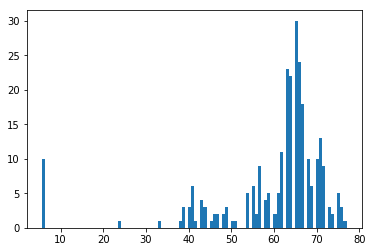

In [322]:
plt.hist(temperature, bins=100)